# Decision Tree On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using Decision Tree algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words(BoW), TF-IDF, Word2Vec, TF-IDF weighted Word2Vec. 

In [3]:
# importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from scipy import stats
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing required libraries
from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prf1

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, minmax_scale

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

## 3. Loading the data

In [4]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
data.shape

(364171, 12)

In [6]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

In [7]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [8]:
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
# converting 'positive' score to 1 and 'negative' score to 0
def partition(x):
    if x == 'positive':
        return 1
    return 0

actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [10]:
sorted_data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [11]:
score = np.array(sorted_data.Score.reshape(sorted_data.shape[0],1))

In [12]:
sorted_data = sorted_data.iloc[:100000,:]
score = score[:100000,:]

In [13]:
sorted_data.shape,score.shape

((100000, 12), (100000, 1))

## 5. Function Definitions

### [A.] Data Spliting 

In [14]:
# Train-Test splitting 
def data_split(data, score):
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size = 0.3, shuffle = False)
    return train_x, test_x, train_y, test_y

### [B.] Decision Tree Classifier

In [15]:
# applying decision tree
def dt(X, Y, vectorizer, name):

    cv_err = []
    train_err = []
    depth = np.arange(2, 25, 2)
    
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=10)
    for train, cv in Kfold.split(X):
        for d in depth:
            
            if name in ['BoW','TFIDF']:
                
                vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
                train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
                cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
                clf = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced') 
                clf.fit(train_vect, Y[train])
                
                train_err.append(1 - (clf.score(train_vect, Y[train])))
                cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            
            elif name == 'Word2Vec':
                
                w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
                train_vect = avg_w2v(X[train], w2v_model)
                cv_vect = avg_w2v(X[cv], w2v_model)
            
                clf = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced') 
                clf.fit(train_vect, Y[train])
                
                cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
                train_err.append(1 - (clf.score(train_vect, Y[train])))
                
            else:
                
                raw_x = vectorizer # its the text data n't a vectorizer for tfidf-w2v 
                X1 = np.array(X)
                w2v_model = gensim.models.Word2Vec(X1[train], min_count=5, size=100, workers=-1)
                tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                train_vect = tfidf_w2v(X[cv.shape[0]:], w2v_model, tfidf_dict)
                cv_vect = tfidf_w2v(X[:cv.shape[0]], w2v_model, tfidf_dict)
                
                train_vect = np.nan_to_num(train_vect)
                cv_vect = np.nan_to_num(cv_vect)
            
                clf = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced') 
                clf.fit(standardizer(train_vect), Y[train])
                
                cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return train_err, cv_err

### [C.] Error Curve 

In [16]:
# comparing model errors on cv and train data
def error_comparision(train_err, cv_err):
    sns.set()
    depth = np.arange(2, 25, 2)
    # plotting error curves
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(depth, cv_err[i, :],label = 'cv_error', color = 'r')
        plt.plot(depth, train_err[i, :],label = 'train_error', color = 'b')
        plt.xlabel('Tree-Depth')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

### [D.] Accuracy Metrics 

In [17]:
# plotting ROC curve along with confusion matrix
def final_test_acc(train_data, train_score, test_data, test_score, depth, name):
    dt = DecisionTreeClassifier(max_depth=depth, class_weight='balanced')
    dt.fit(train_data, train_score)
    
    
    # TRAIN METRIC
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = dt.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for depth = '{0}' is '{1}'".format(depth, acc_trn))
    ytrn_pred_proba = dt.predict_proba(train_data)[::,1]
    fpr0, tpr0, thresholds0 = roc_curve(train_score, ytrn_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='DT', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('DT ROC curve for '+name+' with depth '+str(depth))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(train_score, ytrn_pred_proba))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    # TEST METRIC
    
    print('\n\n\n\n\n')
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = dt.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize=True) * float(100)
    
    print("\nTest accuracy for depth = '{0}' is '{1}'".format(depth, acc))
    y_pred_proba = dt.predict_proba(test_data)[::,1]
    fpr, tpr, thresholds = roc_curve(test_score, y_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='DT', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('DT ROC curve for '+name+' with depth '+str(depth))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(test_score, y_pred_proba))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [E.] Grid Search 

In [18]:
# applying grid search to find best depth 
def grid_search_cv(data_trn, score_trn, data_test, score_test):
    
    tuned_parameters = [{'max_depth': np.arange(2, 25, step = 2)}]
    
    model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tuned_parameters, scoring = 'f1', cv=3, n_jobs=-1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [F.] Random Search 

In [19]:
# applying random search to find best depth
def random_search_cv(data_trn, score_trn, data_test, score_test):
    
    tuned_parameters={'max_depth': stats.norm(10)}
    model = RandomizedSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tuned_parameters, scoring = 'f1', cv=3, n_jobs=-1)
    model.fit(data_trn, score_trn)
                                                                                   
    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [G.] Overal Top Features 

In [94]:
from wordcloud import WordCloud

# finding top features for each class
def top_features_overall(data, score, vectorizer, top_n, d, name):

    clf = DecisionTreeClassifier(max_depth=d, class_weight='balanced')
    clf.fit(data, score)
    imp_features = clf.feature_importances_
    
    # sorting the weight indices 
    imp_sorted =  np.absolute(imp_features).argsort()[::-1]

    # top features
    imp = np.take(vectorizer.get_feature_names(), imp_sorted[:top_n])
    val = np.take(imp_features, imp_sorted[:top_n])
        
    # bar plot of important features
    sns.set()
    plt.figure(figsize=(12, 8))
    imp_plot = sns.barplot(imp, val, color="crimson")
    imp_plot.set_xticklabels(imp, rotation=30)

    # axis labels and title
    plt.ylabel('Importance')
    plt.xlabel('Variable') 
    plt.title('Overall Variable Importance')
    plt.show()
    
    print('Top Features in Word-Cloud\n')
    img_name = name + '_wcloud.png'
    word_dict = {}
    indx = 0
    for word in (np.take(vectorizer.get_feature_names(), imp_sorted)):
        word_dict[str(word)] = (np.take(imp_features, imp_sorted))[indx] * 1000
        indx += 1
                 
    wordcloud = WordCloud(width = 1080, height = 720, 
                background_color ='black',
                min_font_size = 10).fit_words(word_dict)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.savefig(img_name, dpi = 1200)
  
    plt.show() 

In [77]:
# importing tools needed for visualization
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import Image  
import pydotplus

def tree_visual(X, Y, vectorizer, d, name):
    
    dt = DecisionTreeClassifier(max_depth=d, class_weight='balanced')
    dt.fit(X, Y)
    feature_list = vectorizer.get_feature_names()
    
    img_name = name + '_tree.png'
    dot_data = StringIO()

    # exporting the image to a dot file
    export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

    # using dot file to create a graph
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    Image(graph.create_png())

    # writing graph to a png file
    graph.write_png(img_name)

## 6. Bag of Words(BoW)

In [22]:
train_x, test_x, train_y, test_y = data_split(sorted_data, score)

In [23]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(min_df=0)

### [A.] Decision Tree Classifier 

In [25]:
# calculating cv-error and train error
train_err_bow, cv_err_bow = dt(train_x, train_y, count_vect, 'BoW')

In [27]:
cv_err_bow = np.reshape(cv_err_bow,(3, 12))
train_err_bow = np.reshape(train_err_bow,(3, 12))

### [B.] Error Plot Over Different Values of Hyperparameter (Depth of Tree)

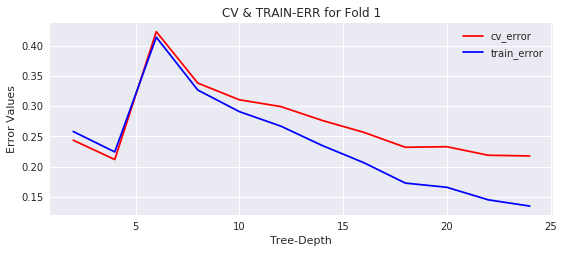

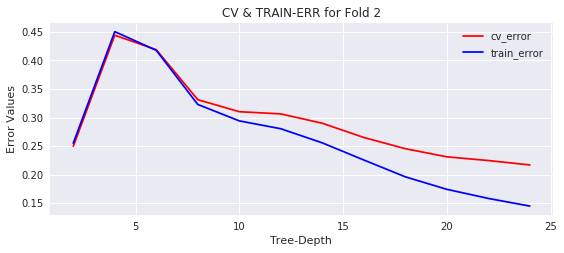

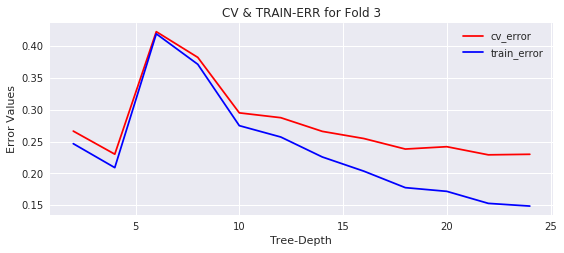

In [28]:
error_comparision(train_err_bow, cv_err_bow)

#### Observation:
* From train and cv error comparision it seems like best depth is in between 25 to 50.

In [29]:
# vectorizer on train and test data
bow_model = count_vect.fit(train_x['CleanedText'].values)
final_counts_train = bow_model.transform(train_x['CleanedText'].values)
final_counts_test = bow_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [30]:
# finding best fit depth using grid search 
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=24, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8652763295099062


### [D.] Random Search 

In [81]:
# finding best fit depth using random search 
random_search_cv(final_counts_train, train_y, final_counts_test, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=300.8373799328965, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.9015239178614156


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for depth = '12' is '73.11714285714285'


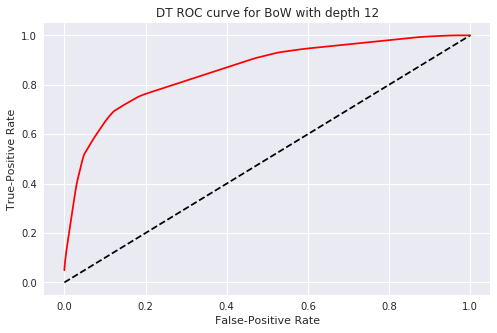

Area under the ROC curve is  0.8555511473128222

Confusion Matrix :
 [[ 7001  1167]
 [17651 44181]]

Normalized Confusion Matrix :
 [[0.85712537 0.14287463]
 [0.28546707 0.71453293]]

Precision  : 28.40%, 97.43%
Recall     : 85.71%, 71.45%
F1-score   : [0.4266301 0.8244262]


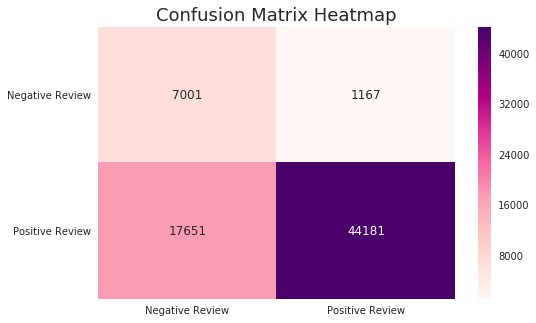







				ACCURACY METRIC FOR TEST-SET


Test accuracy for depth = '12' is '70.82333333333334'


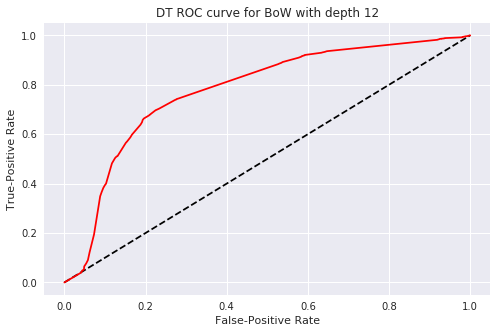

Area under the ROC curve is  0.7762223659785883

Confusion Matrix :
 [[ 3175   928]
 [ 7825 18072]]

Normalized Confusion Matrix :
 [[0.77382403 0.22617597]
 [0.30215855 0.69784145]]

Precision  : 28.86%, 95.12%
Recall     : 77.38%, 69.78%
F1-score   : [0.42044627 0.80504265]


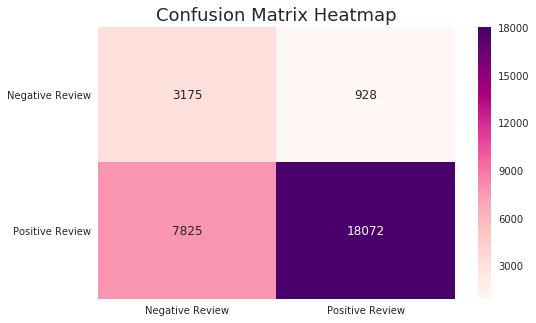

In [34]:
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 12, 'BoW')

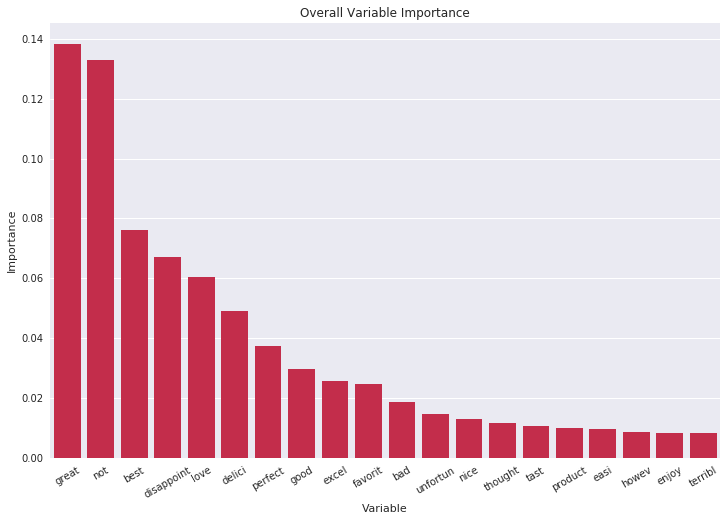

Top Features in Word-Cloud



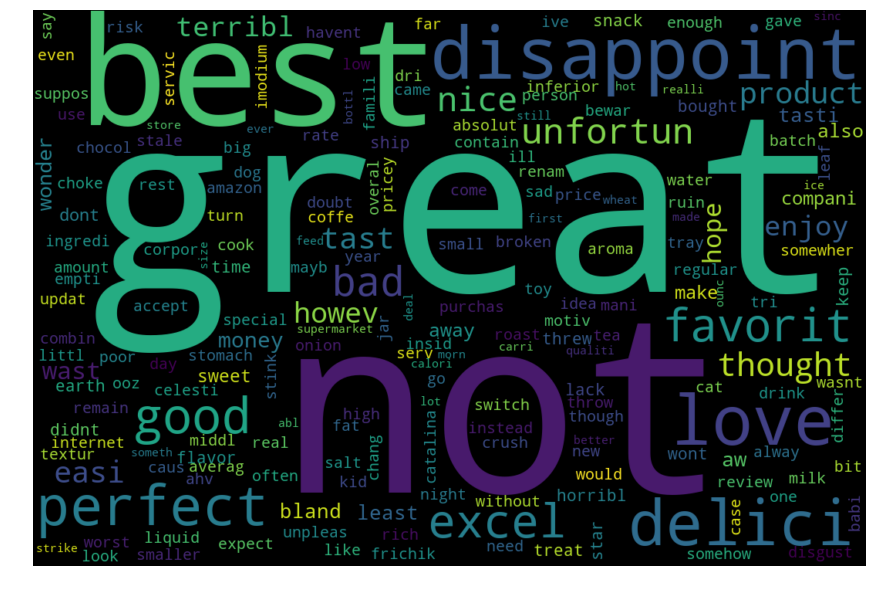

In [73]:
top_features_overall(final_counts_train, train_y, count_vect, 20, 12, 'BoW')

In [80]:
tree_visual(final_counts_train, train_y, count_vect, 4, 'BoW')

####  Tree For BoW with depth 4
![title](img/BoW_tree.png)

## 7. TF-IDF

In [81]:
# applying tf-idf vectorization 
tf_idf_vect = TfidfVectorizer(min_df = 0)

### [A.] Decision Tree Classifier 

In [84]:
train_err_tfidf, cv_err_tfidf = dt(train_x, train_y, tf_idf_vect, 'TFIDF')

In [85]:
cv_err_tfidf = np.reshape(cv_err_tfidf,(3, 12))
train_err_tfidf = np.reshape(train_err_tfidf,(3, 12))

### [B.] Error Plot Over Different Values of Hyperparameter (Depth of Tree)

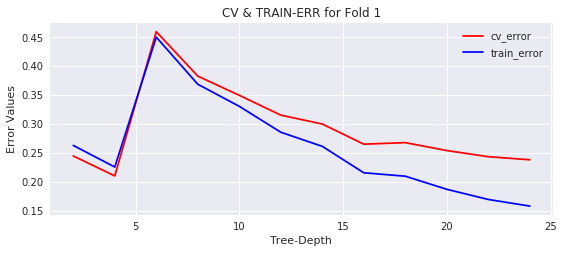

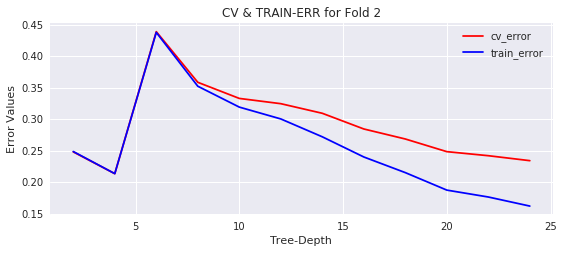

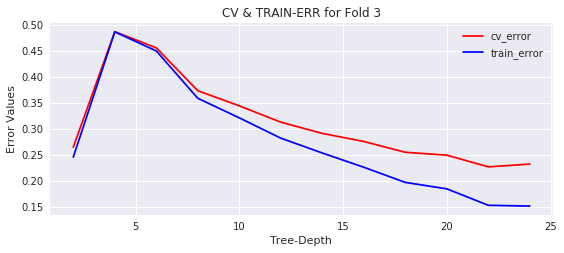

In [86]:
error_comparision(train_err_tfidf, cv_err_tfidf)

#### Observation:
* Best depth seems to be in range 25 to 75. And as the depth increases the model overfits. 

In [87]:
# applying vectorizer to train and test data
tfidf_model = tf_idf_vect.fit(train_x['CleanedText'].values)
final_tfidf_train = tfidf_model.transform(train_x['CleanedText'].values)
final_tfidf_test = tfidf_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [88]:
# finding best fit depth using grid search
grid_search_cv(final_tfidf_train, train_y, final_tfidf_test, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=24, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8463180362860192


### [D.] Random Search 

In [92]:
# finding best fit depth using random search
random_search_cv(final_tfidf_train, train_y, final_tfidf_test, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=299.91317747431356, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.904278817021443


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for depth = '12' is '70.92714285714285'


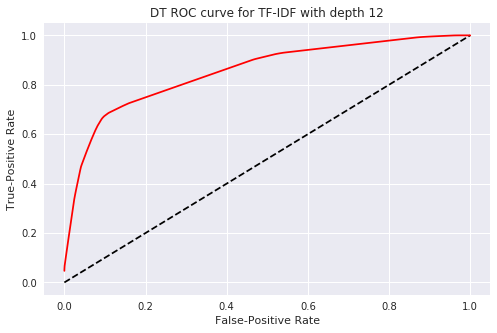

Area under the ROC curve is  0.8520913105956184

Confusion Matrix :
 [[ 7285   883]
 [19468 42364]]

Normalized Confusion Matrix :
 [[0.8918952  0.1081048 ]
 [0.31485315 0.68514685]]

Precision  : 27.23%, 97.96%
Recall     : 89.19%, 68.51%
F1-score   : [0.41722746 0.80632667]


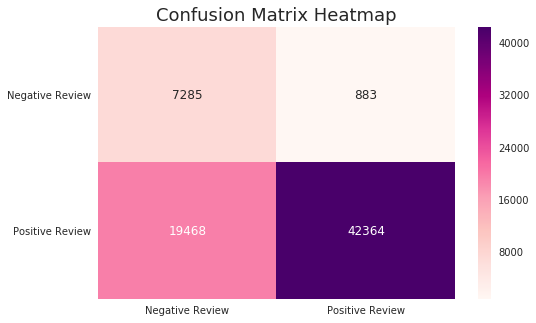







				ACCURACY METRIC FOR TEST-SET


Test accuracy for depth = '12' is '68.63333333333334'


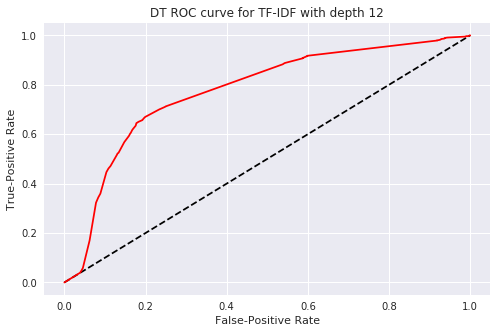

Area under the ROC curve is  0.7745579280772682

Confusion Matrix :
 [[ 3291   812]
 [ 8598 17299]]

Normalized Confusion Matrix :
 [[0.80209603 0.19790397]
 [0.33200757 0.66799243]]

Precision  : 27.68%, 95.52%
Recall     : 80.21%, 66.80%
F1-score   : [0.41158079 0.78617524]


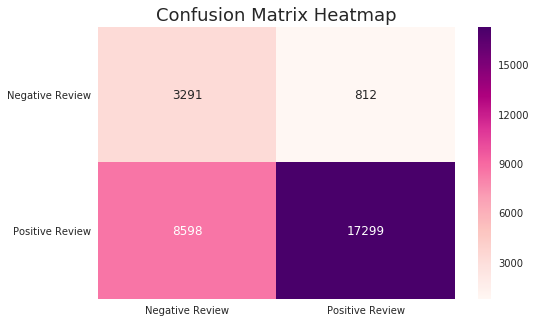

In [91]:
final_test_acc(final_tfidf_train, train_y, final_tfidf_test, test_y, 12, 'TF-IDF')

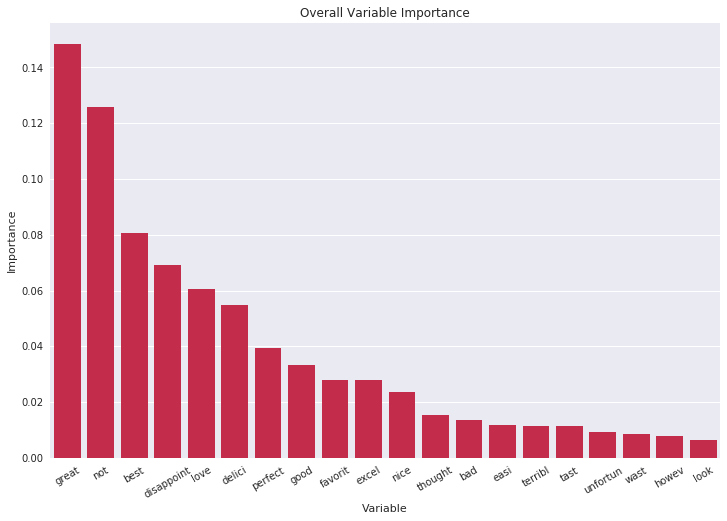

Top Features in Word-Cloud



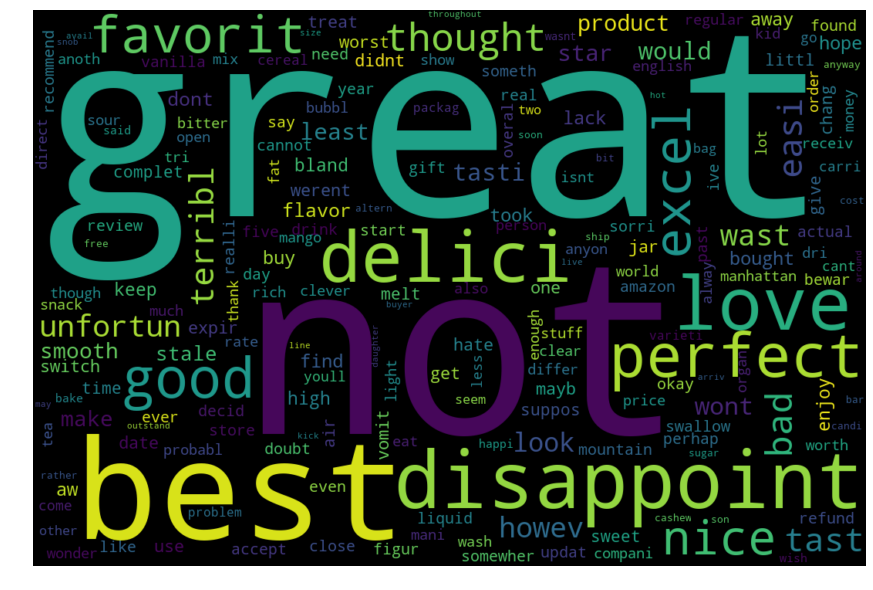

In [95]:
top_features_overall(final_tfidf_train, train_y, tf_idf_vect, 20, 12, 'TFIDF')

In [93]:
tree_visual(final_tfidf_train, train_y, tf_idf_vect, 4, 'TFIDF')

####  Tree For BoW with depth 4
![title](img/TFIDF_tree.png)

## 8. Word2Vec

In [96]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [97]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [98]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [97]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


## 9. Avg Word2Vec & TF-IDF Word2Vec

In [99]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [101]:
train_x, test_x, train_y, test_y = data_split(list_of_sent[:100000], score[:100000])

### [A.] Decision Tree Classifier 

In [102]:
train_w2v, cv_w2v = dt(np.array(train_x), np.array(train_y), None, 'Word2Vec')

In [103]:
cv_wv = np.reshape(cv_w2v,(3, 12))
train_wv = np.reshape(train_w2v,(3, 12))

### [B.] Error Plot Over Different Values of Hyperparameter (Depth of Tree)

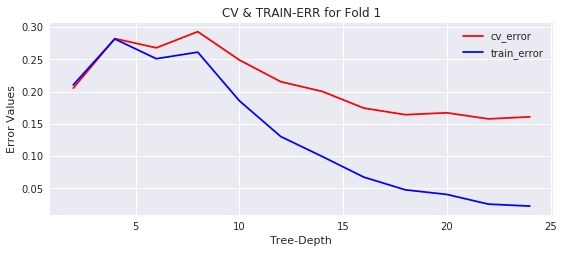

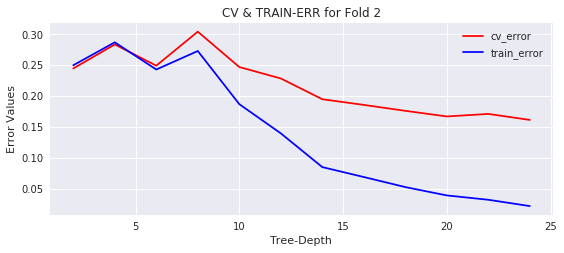

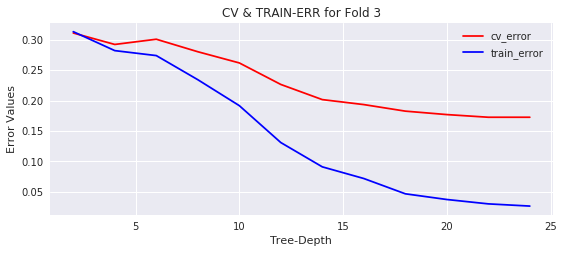

In [106]:
error_comparision(train_wv, cv_wv)

#### Observation:
* Reasonable depth seems to be near to 30 and 50 onwards it overfits the data.

In [107]:
# applying w2v to train and test data
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=8)
train_vect = avg_w2v(train_x, w2v_model)
test_vect = avg_w2v(test_x, w2v_model)

### [C.] Grid Search 

In [108]:
# applying grid search to find best depth 
grid_search_cv(train_vect, train_y, test_vect, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=24, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.894539195744015


### [D.] Random Search 

In [108]:
# applying random search to find best depth
random_search_cv(train_vect, train_y, test_vect, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=300.11133711141485, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.9006275350118619


### [E.] Accuracy Metrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for depth = '6' is '72.44142857142857'


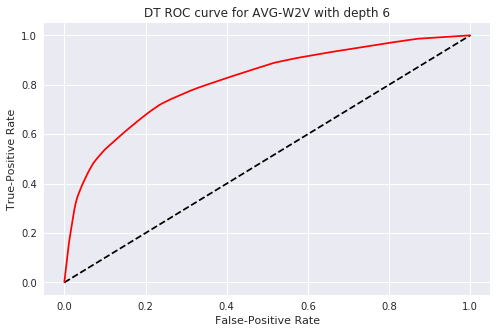

Area under the ROC curve is  0.8128869377453727

Confusion Matrix :
 [[ 6247  1921]
 [17370 44462]]

Normalized Confusion Matrix :
 [[0.76481391 0.23518609]
 [0.2809225  0.7190775 ]]

Precision  : 26.45%, 95.86%
Recall     : 76.48%, 71.91%
F1-score   : [0.3930785  0.82173451]


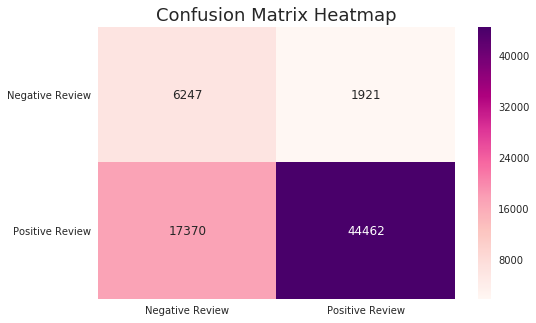







				ACCURACY METRIC FOR TEST-SET


Test accuracy for depth = '6' is '70.97333333333333'


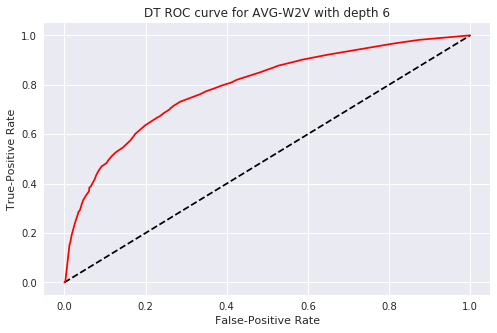

Area under the ROC curve is  0.7895563482515442

Confusion Matrix :
 [[ 3031  1072]
 [ 7636 18261]]

Normalized Confusion Matrix :
 [[0.73872776 0.26127224]
 [0.29486041 0.70513959]]

Precision  : 28.41%, 94.46%
Recall     : 73.87%, 70.51%
F1-score   : [0.41042654 0.80747292]


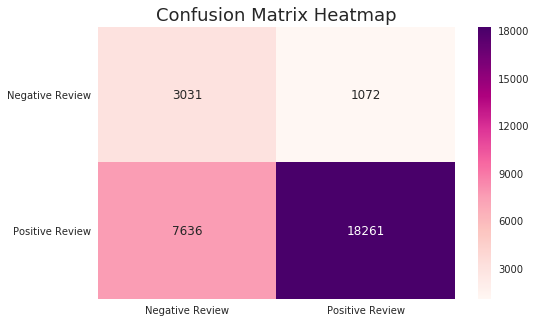

In [109]:
final_test_acc(train_vect, train_y, test_vect, test_y, 6, 'AVG-W2V')

### 9.1 TF-IDF W2V

In [110]:
# Determining TF-IDF weighted Word2Vec
def tfidf_w2v(data, model, tfidf_dict):
    tfidf_feat = tf_idf_vect.get_feature_names() 
    tfidf_sent_vectors = []
    row = 0
    for sent in data: 
        sent_vec = np.zeros(100)
        weight_sum = 0 
        for word in sent: 
            try:
                vec = model.wv[word]
                tf_idf = tfidf_dict[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return np.matrix(tfidf_sent_vectors)

In [111]:
train_x, test_x, train_y, test_y, raw_x, raw_y = train_test_split(list_of_sent[:100000], score[:100000], sorted_data.CleanedText[:100000].values,
                                                                 test_size=0.3, shuffle=False)

### [A.] Decision Tree Classifier

In [115]:
train_err, cv_err = dt(train_x[:100000], train_y[:100000], raw_x[:100000], 'TFIDF-W2V')

In [116]:
cv_err = np.reshape(cv_err,(3, 12))
train_err = np.reshape(train_err,(3, 12))

### [B.] Error Plot Over Different Values of Hyperparameter (Depth of Tree)

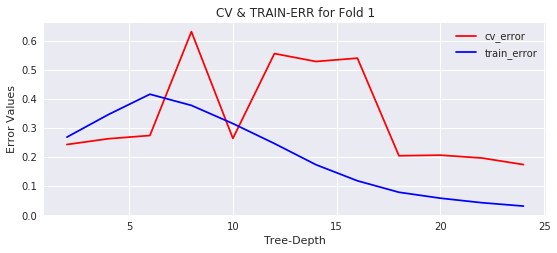

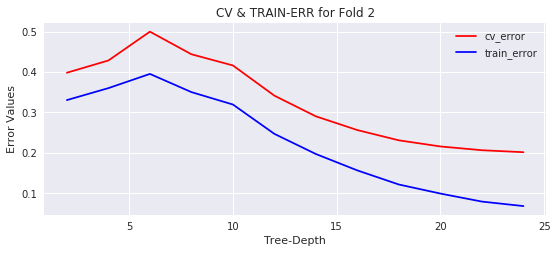

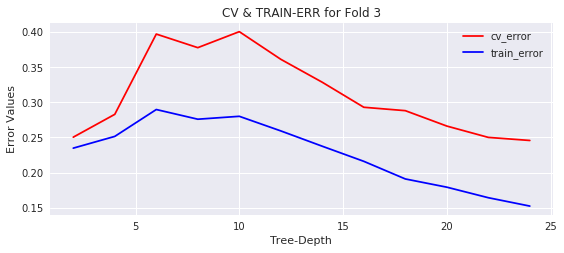

In [117]:
error_comparision(train_err, cv_err)

#### Observation:
* Reasonable depth seems to be near to 30 and model overfits after the depth 50.

In [118]:
# applying tf-idf weighted w2v to train and test set 
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=-1)
tfidf_dict = tf_idf_vect.fit_transform(raw_x)
train_vect = tfidf_w2v(list_of_sent[:70000], w2v_model, tfidf_dict)
test_vect = tfidf_w2v(list_of_sent[70000:100000], w2v_model, tfidf_dict)

In [119]:
train_vect = np.nan_to_num(train_vect)
test_vect = np.nan_to_num(test_vect)

### [C.] Grid Search 

In [83]:
# finding best-fit depth using grid search
grid_search_cv(train_vect, train_y, test_vect, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=61, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8975626130578297


### [D.] Accuracy Metrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for depth = '16' is '85.26'


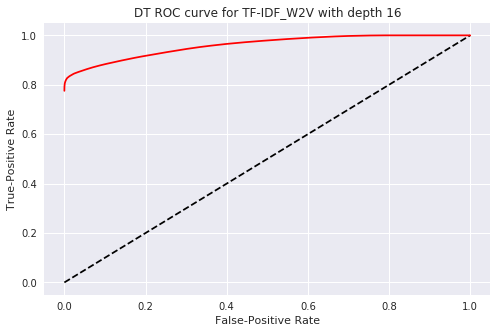

Area under the ROC curve is  0.9596526004906157

Confusion Matrix :
 [[ 8065   103]
 [10215 51617]]

Normalized Confusion Matrix :
 [[0.98738981 0.01261019]
 [0.16520572 0.83479428]]

Precision  : 44.12%, 99.80%
Recall     : 98.74%, 83.48%
F1-score   : [0.60987598 0.90913414]


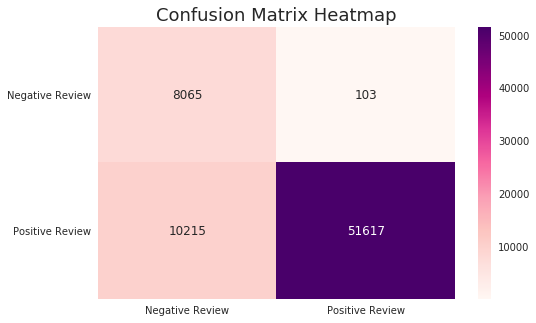







				ACCURACY METRIC FOR TEST-SET


Test accuracy for depth = '16' is '51.51'


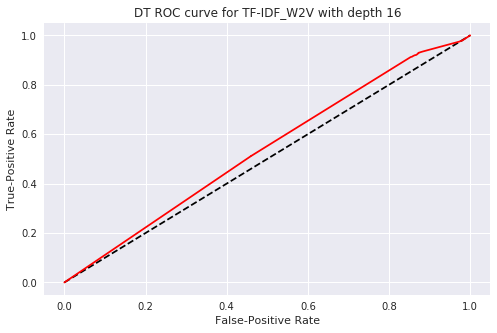

Area under the ROC curve is  0.5374558783563274

Confusion Matrix :
 [[ 2218  1885]
 [12662 13235]]

Normalized Confusion Matrix :
 [[0.54058006 0.45941994]
 [0.48893694 0.51106306]]

Precision  : 14.91%, 87.53%
Recall     : 54.06%, 51.11%
F1-score   : [0.23368277 0.64534218]


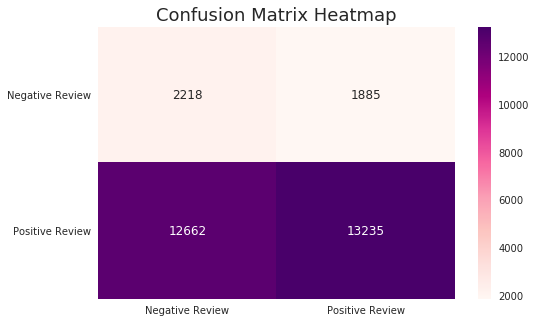

In [122]:
final_test_acc(train_vect, train_y, test_vect, test_y, 16, 'TF-IDF_W2V')

## 10. Summary

### Approach:
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From all Amazon fine food reviews data-points i have taken only the reviews that have score 1, 2, 4 or 5. Then I applied some pre-processing methods to make data best fit to apply naive bayes model. After that I have declared some useful functions to modularize the whole process. For our end goal i.e to classify a review whether it is positive or not by using support vector classifier, we need to convert the textual data to numerial one. To do so i have used these four(given below) vectorization methods.<br>
</p>
<br>
1. Bag of Words(BoW)<br>
2. TF-IDF<br>
3. Avg Word2Vec<br>
4. TF-IDF W2V
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before applying any model to our data we need to split the data into train and test set. Here I have taken 70% of the data(100000 datapoints) as train-set and rest 30% as test-data. The important part here is "I have sorted the data in ascending order of time stamp of the reviews" and then splitted the whole data without shuffling it". The only problem with this data set is that it is a imbalanced dataset i.e there is a mismatch between number of instances of each class. Here i'm having 87729 positive data-points and 12271 negative data-points. It means the given dataset is nearly 87.7% positive & 12.3% negative. 
</p>

<h3> Results:</h3>
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Decision Tree we have got max_depth which is a hyper-parameter which handles the trade-off between overfitting and underfitting. To find best fit depth I have used 3-Fold cross validation for each vectorization method and the performance of the model is compared by various accuracy matrics(ROC-AUC curve, precision, recall, F1-Score etc.) for each vectorization.
</p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>1. BoW</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For BoW representation, we got best-fit depth = 50 from 3-Fold cross validation and grid search. And the accuracy metric for train and test data, taking depth = 50, is given below:-
 <table>
  <tr>
    <th>Data</th>
    <th>Depth</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>50</td>
    <td>93.76%</td>
    <td>65.41%, 99.84%</td>
    <td>98.87%, 93.09%</td>
    <td>0.79 0.96</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>50</td>
    <td>82.56%</td>
    <td>41.05%, 93.61%</td>
    <td>63.08%, 85.65%</td>
    <td>0.50 0.89</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 93.76% accuracy for train-data and 82.56% for test-data. But from F1-Score it is clear that our model is not that good in predicting negative class compared to the positive prediction. This problem occurs due the imbalanced data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>2. TF-IDF</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For TF-IDF representation, we got best-fit depth = 60 from 3-Fold cross validation. And the accuracy metric for train and test data, taking depth = 60, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Depth</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>60</td>
    <td>94%</td>
    <td>65.87%, 100.00%</td>
    <td>99.99%, 93.16%</td>
    <td>0.79 0.96</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>60</td>
    <td>81.71%</td>
    <td>38.97%, 93.02%</td>
    <td>59.61%, 85.21%</td>
    <td>0.47 0.89</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 94% accuracy with reasonable F1-Scores for train-data and 81.71% for test-data. But for test-data, negative class F1-Score is 0.47 which is too low compared to positive class F1-Score 0.89.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>3. Avg Word2Vec</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit depth = 60 from 3-Fold cross validation. And the accuracy metric for train and test data, taking depth = 60, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Depth</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>60</td>
    <td>99.9%</td>
    <td>99.91%, 100.00%</td>
    <td>100.00%, 99.99%</td>
    <td>0.99 0.99</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>60</td>
    <td>82.6%</td>
    <td>34.44%, 89.17%</td>
    <td>30.32%, 90.86%</td>
    <td>0.32 0.90</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 99.9% accuracy with high F1-Scores for train-data and 82.6% for test-data. But for test-data, negative class F1-Score is poor i.e 0.32 which is worse compared to positive class F1-Score 0.90. So Avg Word2Vec didn't help the model to properly classify the given data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>4. TF-IDF W2V</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit depth = 12 from 3-Fold cross validation. And the accuracy metric for train and test data, taking depth = 12, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Depth</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>12</td>
    <td>73.85%</td>
    <td>29.54%, 98.11%</td>
    <td>89.52%, 71.79%</td>
    <td>0.44 0.83</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>12</td>
    <td>77.56%</td>
    <td>19.38%, 87.28%</td>
    <td>20.28%, 86.64%</td>
    <td>0.20 0.87</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 73.85% accuracy with worse negative F1-Score for train-data and 77.56% for test-data. But for test-data, negative class F1-Score is the worst among all other i.e 0.20.<br>
<h3> Conclusion:</h3><br>
1. Decision Tree did not do well in any of the vectorization method as highest F1 score obtained for negative class is 0.50 only.<br> 
2. One reason could be that the data is imbalanced, still other models performed fairly well. That is why Decision Tree is not being used for text-based classification task where the dimention is very large.<br>